In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_curve,recall_score, f1_score, precision_score, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


In [5]:
df = pd.read_csv("creditcard.csv")
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Time','Amount'],axis=1)

In [9]:
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']


In [10]:
# Number of data points in the minority class
number_records_fraud = len(df[df.Class == 1])
fraud_indices = np.array(df[df.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = df[df.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = df.iloc[under_sample_indices,:]

X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


In [13]:

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


In [40]:
def parameter_tuning_KFOLD_scores(x_train_data,y_train_data):
    fold = KFold(n_splits=5,shuffle=False) 

    # Testing the best parameters for C
    c_params = [0.01,0.1,1,10,100]

    results_df= pd.DataFrame(index = range(len(c_params),2), columns = ['c_parameter','Mean recall score'])
    results_df['c_parameter'] = c_params

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    idx = 0
    for c_param in c_params:
        print('-------------------------------------------')
        print('c parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        for iteration, indices in enumerate(fold.split(x_train_data),start=1):
            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C=c_param, penalty='l1', solver='liblinear')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_df.loc[idx,'Mean recall score'] = np.mean(recall_accs)
        idx += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    best_c = results_df.loc[results_df['Mean recall score'].idxmax()]['c_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [41]:
regularization_paramter = parameter_tuning_KFOLD_scores(X_train_undersample,y_train_undersample)

-------------------------------------------
c parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.9315068493150684
Iteration  2 : recall score =  0.9178082191780822
Iteration  3 : recall score =  1.0
Iteration  4 : recall score =  0.972972972972973
Iteration  5 : recall score =  0.9545454545454546

Mean recall score  0.9553666992023157

-------------------------------------------
c parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.8493150684931506
Iteration  2 : recall score =  0.863013698630137
Iteration  3 : recall score =  0.9152542372881356
Iteration  4 : recall score =  0.9324324324324325
Iteration  5 : recall score =  0.8939393939393939

Mean recall score  0.89079096615665

-------------------------------------------
c parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.863013698630137
Iteration  2 : recall score =  0.9041095890410958
Iteration  3 : recal

/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not h

Iteration  1 : recall score =  0.8767123287671232
Iteration  2 : recall score =  0.8904109589041096
Iteration  3 : recall score =  0.9661016949152542
Iteration  4 : recall score =  0.9459459459459459
Iteration  5 : recall score =  0.9090909090909091

Mean recall score  0.9176523675246685

*********************************************************************************
Best model to choose from cross validation is with C parameter =  0.01
*********************************************************************************


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not h

In [42]:
lr = LogisticRegression(C=regularization_paramter, penalty='l1', solver='liblinear')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [44]:
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))


Recall metric in the testing dataset:  0.9115646258503401


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


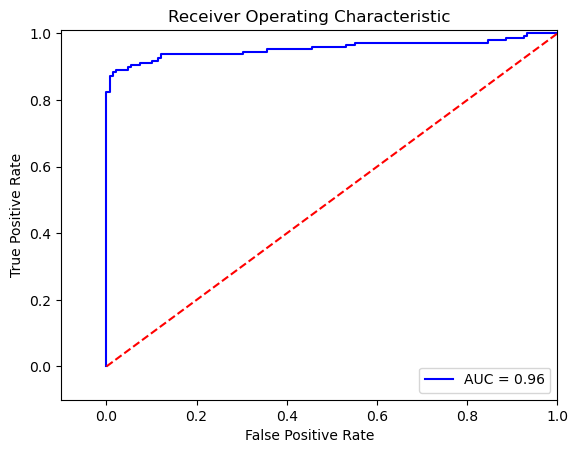

In [46]:
# ROC CURVE
lr = LogisticRegression(C=regularization_paramter, penalty='l1', solver='liblinear')
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
regularization_paramter_all_training = parameter_tuning_KFOLD_scores(X_train,y_train)

-------------------------------------------
c parameter:  0.01
-------------------------------------------



/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  1 : recall score =  0.4925373134328358


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  2 : recall score =  0.6027397260273972


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  3 : recall score =  0.6833333333333333


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  4 : recall score =  0.5692307692307692


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  5 : recall score =  0.45

Mean recall score  0.5595682284048672

-------------------------------------------
c parameter:  0.1
-------------------------------------------



/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  1 : recall score =  0.5671641791044776


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  2 : recall score =  0.6164383561643836


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  3 : recall score =  0.6833333333333333


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  4 : recall score =  0.5846153846153846


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  5 : recall score =  0.525

Mean recall score  0.5953102506435158

-------------------------------------------
c parameter:  1
-------------------------------------------



/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  1 : recall score =  0.5522388059701493


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  2 : recall score =  0.6164383561643836


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  3 : recall score =  0.7166666666666667


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  4 : recall score =  0.6153846153846154


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  5 : recall score =  0.5625

Mean recall score  0.612645688837163

-------------------------------------------
c parameter:  10
-------------------------------------------



/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  1 : recall score =  0.5522388059701493


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  2 : recall score =  0.6164383561643836


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  3 : recall score =  0.7333333333333333


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  4 : recall score =  0.6153846153846154


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  5 : recall score =  0.575

Mean recall score  0.6184790221704963

-------------------------------------------
c parameter:  100
-------------------------------------------



/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  1 : recall score =  0.5522388059701493


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  2 : recall score =  0.6164383561643836


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  3 : recall score =  0.7333333333333333


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Iteration  4 : recall score =  0.6153846153846154
Iteration  5 : recall score =  0.575

Mean recall score  0.6184790221704963

*********************************************************************************
Best model to choose from cross validation is with C parameter =  10.0
*********************************************************************************


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [49]:
lr = LogisticRegression(C=regularization_paramter_all_training, penalty='l1', solver='liblinear')
lr.fit(X_train,y_train.values.ravel())
y_pred_undersample = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))


Recall metric in the testing dataset:  0.6190476190476191


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [50]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Building the model
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))  # First hidden layer
model.add(Dense(15, activation='relu'))  # Second hidden layer with 15 neurons
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

Epoch 1/100
19937/19937 [==============================] - 10s 463us/step - loss: 0.0076 - accuracy: 0.9987
Epoch 2/100
19937/19937 [==============================] - 10s 518us/step - loss: 0.0033 - accuracy: 0.9993
Epoch 3/100
19937/19937 [==============================] - 10s 502us/step - loss: 0.0030 - accuracy: 0.9994
Epoch 4/100
19937/19937 [==============================] - 9s 471us/step - loss: 0.0028 - accuracy: 0.9993
Epoch 5/100
19937/19937 [==============================] - 10s 505us/step - loss: 0.0027 - accuracy: 0.9994
Epoch 6/100
19937/19937 [==============================] - 12s 592us/step - loss: 0.0025 - accuracy: 0.9994
Epoch 7/100
19937/19937 [==============================] - 9s 462us/step - loss: 0.0025 - accuracy: 0.9994
Epoch 8/100
19937/19937 [==============================] - 9s 456us/step - loss: 0.0025 - accuracy: 0.9994
Epoch 9/100
19937/19937 [==============================] - 11s 563us/step - loss: 0.0024 - accuracy: 0.9994
Epoch 10/100
19937/19937 [=====

In [63]:
# Compute class weights for imbalanced data
# Ensure y_train is a 1D array, not a column vector or multi-column DataFrame
y_train_array = y_train.values.ravel()

# Compute the class weights, using the unique labels in y_train_array
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_array), y=y_train_array)

# Create a dictionary mapping the class label to the computed class weight
class_weights_dict = {label: weight for label, weight in zip(np.unique(y_train_array), class_weights)}


model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))  # First hidden layer
model.add(Dropout(0.3))  # Dropout layer to reduce overfitting
model.add(Dense(15, activation='relu'))  # Second hidden layer
model.add(Dropout(0.3))  # Another dropout layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights due to imbalance
model.fit(X_train, y_train, epochs=20, batch_size=10, verbose=1, class_weight=class_weights_dict, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the scaled test data
X_test_scaled = scaler.fit_transform(X_test)
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/20
15950/15950 [==============================] - 11s 671us/step - loss: 0.5395 - accuracy: 0.8825 - val_loss: 0.0864 - val_accuracy: 0.9721
Epoch 2/20
15950/15950 [==============================] - 10s 632us/step - loss: 0.2609 - accuracy: 0.9400 - val_loss: 0.0273 - val_accuracy: 0.9896
Epoch 3/20
15950/15950 [==============================] - 10s 621us/step - loss: 0.2876 - accuracy: 0.9520 - val_loss: 0.0476 - val_accuracy: 0.9909
Epoch 4/20
15867/15950 [============================>.] - ETA: 0s - loss: 0.2740 - accuracy: 0.9477

2671/2671 [==============================] - 1s 407us/step


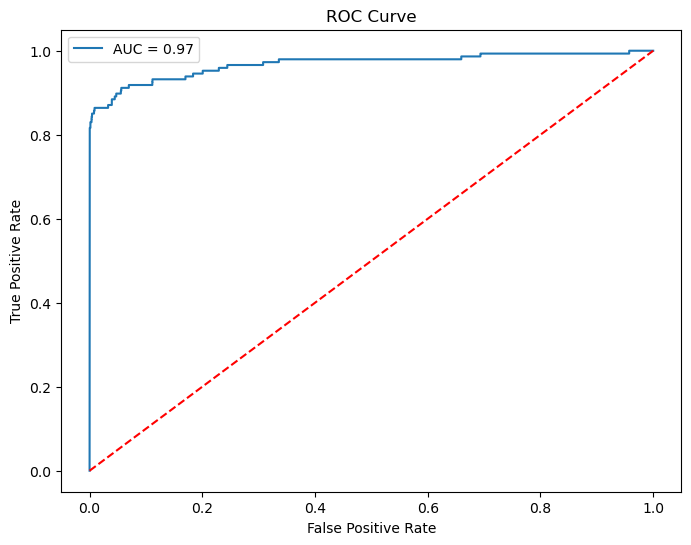

In [58]:
# Making probability predictions
y_pred_probs = model.predict(X_test_scaled).ravel()  # assuming X_test_scaled is your scaled test set
y_pred_binary = (y_pred_probs > 0.5).astype('int')

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)  # ROC curve
auc_score = roc_auc_score(y_test, y_pred_probs)         # AUC score

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [59]:


f1 = f1_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

Precision: 0.23
Recall: 0.85
F1-Score: 0.37


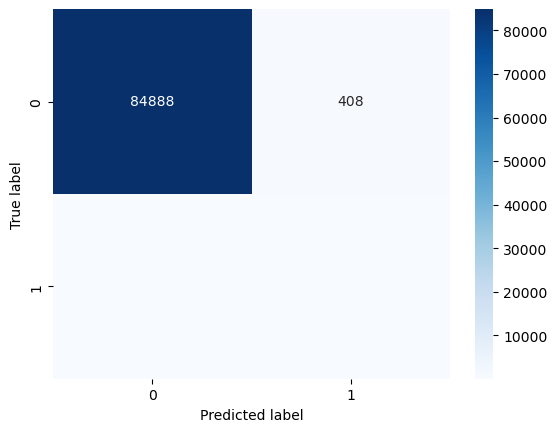

In [60]:

cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()